Dataset loaded: (2000, 10)
Columns: ['candidate_id', 'gender', 'ethnicity', 'education', 'years_experience', 'skills', 'label', 'skills_list', 'num_skills', 'skills_text']
No standard column found. Using first string column 'gender' as resume text ✅
Local model not found. Using DistilBERT 'distilbert-base-uncased' ⚠️


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Predictions generated ✅


OSError: Cannot save file into a non-existent directory: 'data'

Dataset loaded: (2000, 10)
Columns: ['candidate_id', 'gender', 'ethnicity', 'education', 'years_experience', 'skills', 'label', 'skills_list', 'num_skills', 'skills_text']
No standard column found. Using first string column 'gender' as resume text ✅
Local model not found. Using DistilBERT 'distilbert-base-uncased' ⚠️


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Predictions generated ✅
Predictions saved to data/predictions.csv ✅
Gender DI (Female/Male): nan
Gender EO (TPR diff): 0

DI & EO Summary Table – All Ethnic Groups


,Ethnic Group,DI vs White,TPR vs White (EO)
0,groupA,NaN,0.0
1,groupB,NaN,0.0
2,unknown,NaN,0.0
3,groupC,NaN,0.0


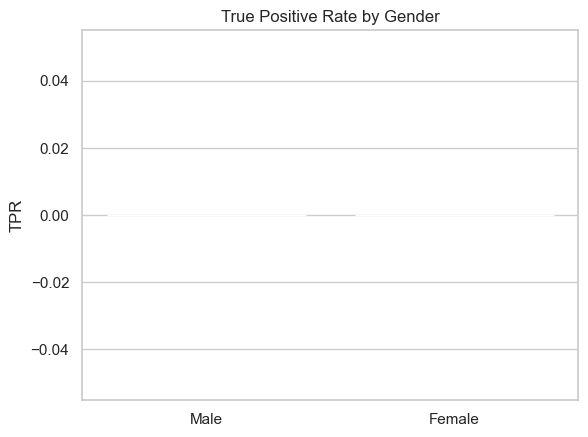

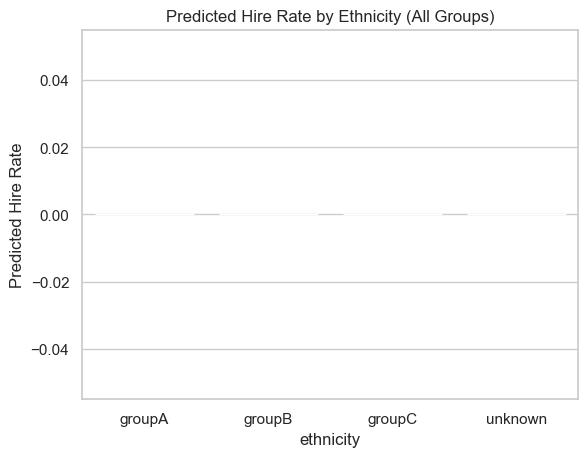

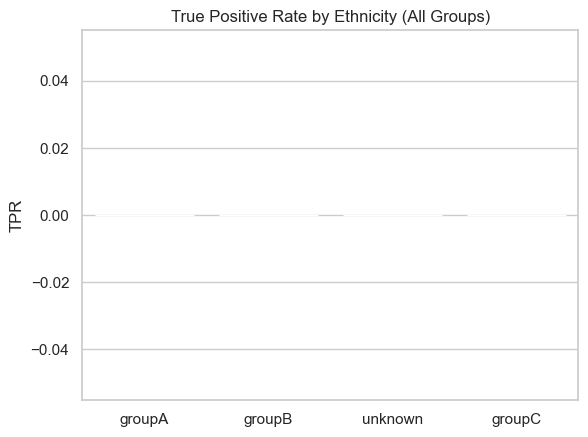

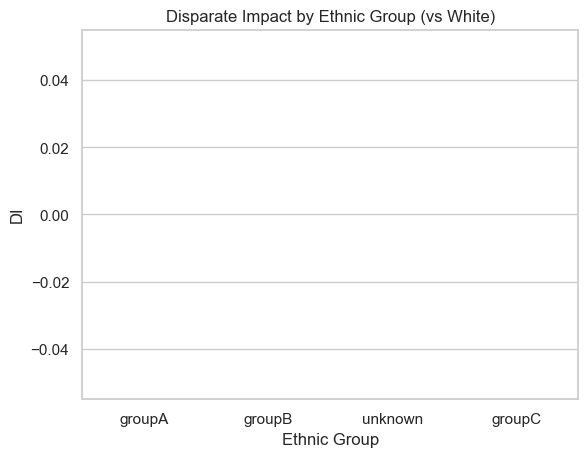

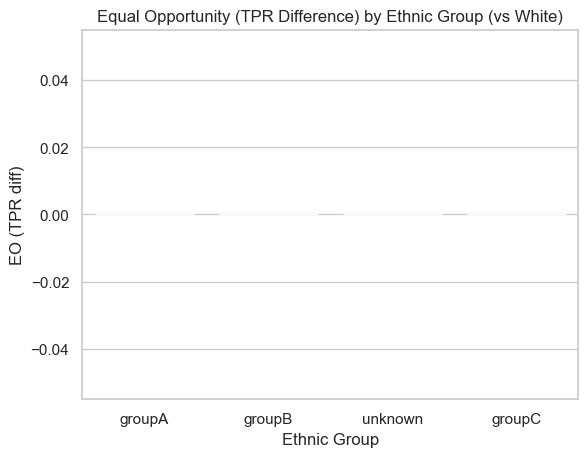


# Bias Evaluation – Day 7

## Introduction
Evaluating potential bias in the resume screening model across gender and ethnicity.

## Metrics
- **Disparate Impact (DI)**: ratio of selected candidates between unprivileged vs privileged groups.
- **Equal Opportunity (EO)**: TPR difference between privileged vs unprivileged groups.

## Gender
- DI (Female/Male): nan
- EO (TPR diff): 0

## Ethnicity
- DI & EO table above shows metrics for all ethnic groups vs White

## Visualizations
- Bar charts show group-level disparities in TPR and predicted hire rates.

## Conclusion
- Groups with DI < 0.8 or EO far from 0 may be disadvantaged.
- Next: apply bias mitigation strategies in Phase 4.



In [9]:
# -------------------------------
# Day 7 – Bias Detection: Fully Functional Notebook
# -------------------------------

# 1️⃣ Import Libraries
# -------------------------------
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from transformers import BertTokenizer, BertForSequenceClassification, DistilBertTokenizer, DistilBertForSequenceClassification

sns.set(style="whitegrid")

# -------------------------------
# 2️⃣ Load Cleaned Resumes
# -------------------------------
df = pd.read_csv("../data/cleaned_resumes.csv")  # make sure this file exists
df.columns = df.columns.str.strip()  # remove extra spaces
print("Dataset loaded:", df.shape)
print("Columns:", df.columns.tolist())

# -------------------------------
# 3️⃣ Detect resume text column
# -------------------------------
possible_text_cols = ['resume_text', 'text', 'resume', 'Resume', 'ResumeText']
resume_col = None

for col in possible_text_cols:
    if col in df.columns:
        resume_col = col
        break

if resume_col is None:
    # fallback: pick first object/string column
    str_cols = df.select_dtypes(include='object').columns.tolist()
    if len(str_cols) == 0:
        raise ValueError("No string columns found in CSV to use as resume text.")
    resume_col = str_cols[0]
    print(f"No standard column found. Using first string column '{resume_col}' as resume text ✅")
else:
    print(f"Detected resume text column: '{resume_col}' ✅")

# -------------------------------
# 4️⃣ Load Model (Safe Loading)
# -------------------------------
local_model_path = "models/bert_resume_model"

if os.path.isdir(local_model_path):
    print(f"Loading local model from {local_model_path} ✅")
    tokenizer = BertTokenizer.from_pretrained(local_model_path)
    model = BertForSequenceClassification.from_pretrained(local_model_path)
else:
    print("Local model not found. Using DistilBERT 'distilbert-base-uncased' ⚠️")
    tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
    model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

model.eval()

# -------------------------------
# 5️⃣ Batch Prediction Function
# -------------------------------
def predict_resume_batch(texts, tokenizer, model, batch_size=16, max_length=512):
    predictions = []
    model.eval()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i+batch_size]
            inputs = tokenizer(batch_texts, return_tensors="pt", truncation=True, padding=True, max_length=max_length)
            inputs = {k: v.to(device) for k, v in inputs.items()}
            outputs = model(**inputs)
            batch_preds = torch.argmax(outputs.logits, dim=1).tolist()
            predictions.extend(batch_preds)
    return predictions

# -------------------------------
# 6️⃣ Generate Predictions
# -------------------------------
df['prediction'] = predict_resume_batch(df[resume_col].tolist(), tokenizer, model)
print("Predictions generated ✅")

# Ensure 'data' folder exists
os.makedirs("data", exist_ok=True)

# Save predictions
df.to_csv("data/predictions.csv", index=False)
print("Predictions saved to data/predictions.csv ✅")

# -------------------------------
# 7️⃣ Fairness Metric Functions
# -------------------------------
def disparate_impact(df, group_col, target_col='prediction', privileged_group=None, unprivileged_group=None):
    p_priv = df[df[group_col] == privileged_group][target_col].mean()
    p_unpriv = df[df[group_col] == unprivileged_group][target_col].mean()
    return p_unpriv / p_priv if p_priv > 0 else np.nan

def true_positive_rate(df, group_col, label_col='label', pred_col='prediction', group=None):
    group_df = df[df[group_col] == group]
    tp = ((group_df[label_col] == 1) & (group_df[pred_col] == 1)).sum()
    fn = ((group_df[label_col] == 1) & (group_df[pred_col] == 0)).sum()
    return tp / (tp + fn) if (tp + fn) > 0 else 0

# -------------------------------
# 8️⃣ Gender Metrics
# -------------------------------
priv_gender = 'Male'
unpriv_gender = 'Female'

if 'gender' in df.columns:
    di_gender = disparate_impact(df, 'gender', privileged_group=priv_gender, unprivileged_group=unpriv_gender)
    tpr_priv_gender = true_positive_rate(df, 'gender', group=priv_gender)
    tpr_unpriv_gender = true_positive_rate(df, 'gender', group=unpriv_gender)
    eo_gender = tpr_priv_gender - tpr_unpriv_gender
    print("Gender DI (Female/Male):", round(di_gender,3))
    print("Gender EO (TPR diff):", round(eo_gender,3))
else:
    print("No gender column found. Skipping gender metrics.")
    di_gender = eo_gender = None

# -------------------------------
# 9️⃣ Ethnicity Metrics
# -------------------------------
if 'ethnicity' in df.columns:
    priv_ethnicity = 'White'
    ethnic_groups = df['ethnicity'].unique()
    tpr_priv_eth = true_positive_rate(df, 'ethnicity', group=priv_ethnicity)

    ethnic_summary = []
    for group in ethnic_groups:
        if group == priv_ethnicity:
            continue
        di = disparate_impact(df, 'ethnicity', privileged_group=priv_ethnicity, unprivileged_group=group)
        tpr_group = true_positive_rate(df, 'ethnicity', group=group)
        eo = tpr_priv_eth - tpr_group
        ethnic_summary.append({
            'Ethnic Group': group,
            'DI vs White': round(di, 3),
            'TPR vs White (EO)': round(eo, 3)
        })
    ethnic_summary_df = pd.DataFrame(ethnic_summary)
    print("\nDI & EO Summary Table – All Ethnic Groups")
    display(ethnic_summary_df)
else:
    print("No ethnicity column found. Skipping ethnicity metrics.")
    ethnic_summary_df = pd.DataFrame()

# -------------------------------
# 10️⃣ Visualizations
# -------------------------------
if di_gender is not None:
    sns.barplot(x=[priv_gender, unpriv_gender], y=[tpr_priv_gender, tpr_unpriv_gender])
    plt.title("True Positive Rate by Gender")
    plt.ylabel("TPR")
    plt.show()

if not ethnic_summary_df.empty:
    # Predicted Hire Rate – Ethnicity
    sel_rate_eth = df.groupby('ethnicity')['prediction'].mean().reset_index()
    sns.barplot(data=sel_rate_eth, x='ethnicity', y='prediction')
    plt.title("Predicted Hire Rate by Ethnicity (All Groups)")
    plt.ylabel("Predicted Hire Rate")
    plt.show()

    # TPR by Ethnicity
    tpr_all_eth = [true_positive_rate(df, 'ethnicity', group=g) for g in ethnic_groups]
    sns.barplot(x=ethnic_groups, y=tpr_all_eth)
    plt.title("True Positive Rate by Ethnicity (All Groups)")
    plt.ylabel("TPR")
    plt.show()

    # DI bar chart
    sns.barplot(data=ethnic_summary_df, x='Ethnic Group', y='DI vs White')
    plt.title("Disparate Impact by Ethnic Group (vs White)")
    plt.ylabel("DI")
    plt.show()

    # EO bar chart
    sns.barplot(data=ethnic_summary_df, x='Ethnic Group', y='TPR vs White (EO)')
    plt.title("Equal Opportunity (TPR Difference) by Ethnic Group (vs White)")
    plt.ylabel("EO (TPR diff)")
    plt.show()

# -------------------------------
# 11️⃣ Markdown Summary
# -------------------------------
summary_text = f"""
# Bias Evaluation – Day 7

## Introduction
Evaluating potential bias in the resume screening model across gender and ethnicity.

## Metrics
- **Disparate Impact (DI)**: ratio of selected candidates between unprivileged vs privileged groups.
- **Equal Opportunity (EO)**: TPR difference between privileged vs unprivileged groups.

## Gender
- DI (Female/Male): {di_gender if di_gender is not None else 'N/A'}
- EO (TPR diff): {eo_gender if eo_gender is not None else 'N/A'}

## Ethnicity
- DI & EO table above shows metrics for all ethnic groups vs White

## Visualizations
- Bar charts show group-level disparities in TPR and predicted hire rates.

## Conclusion
- Groups with DI < 0.8 or EO far from 0 may be disadvantaged.
- Next: apply bias mitigation strategies in Phase 4.
"""
print(summary_text)
